In [ ]:
#| default_exp 04-metadata-augmented-trie-for-distilbert

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, pandas as pd, warnings, torch
from tqdm.auto import tqdm
from scipy import stats

from xcai.basics import *
from xcai.models.MMM00X import DBT007, DBT008

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
block = XCBlock.from_cfg('data_meta', valid_pct=0.001, tokz='distilbert-base-uncased')

/home/scai/phd/aiz218323/.local/lib/python3.9/site-packages/xclib-0.97-py3.9-linux-x86_64.egg/xclib/data/data_utils.py:263: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")
/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
test_dset = block.test.dset.sample(n=2000, seed=50)

# Generation

In [ ]:
#| export
mname = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-168000'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0)

Some weights of DBT007 were not initialized from the model checkpoint at /scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-168000 and are newly initialized: ['loss_fn.o']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
args = XCLearningArguments(
    output_dir='/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K',
    generation_length_penalty=1.5,
    per_device_eval_batch_size=64,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the envi

## `trie`

In [ ]:
trie = XCTrie.from_block(block)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [ ]:
learn.tbs.trie = trie

In [ ]:
# learn.tbs.n_bm = learn.args.generation_num_beams = 10
learn.tbs.n_bm = learn.args.generation_num_beams = 200

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,14.75,9.4167,7.02,4.315,14.75,14.0973,14.4223,15.32,9.5034,9.823,10.5744,11.8374,9.5034,10.0717,10.6902,11.553,11.0962,12.5705,17.4861,17.7099,17.7099,17.7099,7.9235,320.0781,6.248,0.05


the metric on a sample of 2000 datapoints

In [ ]:
metric = {'test_loss': 7.9235124588012695, 'test_P@1': 0.1325, 'test_P@10': 0.03425000000000011, 'test_P@3': 0.08066666666666672, 
          'test_P@5': 0.0574000000000003, 'test_N@1': 0.13249999284744263, 'test_N@10': 0.132889062166214, 'test_N@3': 0.12606960535049438, 
          'test_N@5': 0.1266314685344696, 'test_PSP@1': 0.08500534533966667, 'test_PSP@10': 0.09062216879025282, 
          'test_PSP@3': 0.08281493343077471, 'test_PSP@5': 0.08468174886420247, 'test_PSN@1': 0.08500534296035767, 
          'test_PSN@10': 0.09795131534337997, 'test_PSN@3': 0.0890892967581749, 'test_PSN@5': 0.09245995432138443, 
          'test_R@2': 0.1012909469615352, 'test_R@3': 0.11492171896730717, 'test_R@100': 0.23083656160579327, 
          'test_R@200': 0.2763073646933462, 'test_R@10': 0.1474227239264004, 'test_R@50': 0.19989910379934445, 'test_runtime': 4973.0083, 
          'test_samples_per_second': 0.402, 'test_steps_per_second': 0.003}

display_metric(metric)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,13.25,8.0667,5.74,3.425,13.25,12.607,12.6631,13.2889,8.5005,8.2815,8.4682,9.0622,8.5005,8.9089,9.246,9.7951,10.1291,11.4922,14.7423,19.9899,23.0837,27.6307,7.9235,4973.0083,0.402,0.003


## `meta-augmented trie`

In [ ]:
#| export
a_trie = XCTrie.from_block(block, meta=['hlk'])

  0%|          | 0/312330 [00:00<?, ?it/s]

  0%|          | 0/2458399 [00:00<?, ?it/s]

In [ ]:
#| export
learn.tbs.trie = a_trie

In [ ]:
#| export
learn.tbs.n_bm = learn.args.generation_num_beams = 20

In [ ]:
#| export
o = learn.predict(block.test.dset)
print(o.metrics)

#display_metric(o.metrics)

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,7.35,4.2333,3.12,1.935,7.35,6.9018,7.1541,7.6512,4.845,4.7187,4.9592,5.5679,4.845,5.1061,5.4189,5.8523,5.6319,6.4303,8.9982,14.5662,18.1612,21.8284,7.9235,525.123,3.809,0.03


In [ ]:
#| export
# torch.save(o, f'{mname}/predictions/test_lbl_atrie-hlk_n-smp-2000_seed-50.pth')
torch.save(o, f'{mname}/predictions/test_lbl_atrie-hlk.pth')

In [ ]:
o

XCPredictionOutput(pred_idx=tensor([200462, 122501, 193102,  ..., 173982, 222905, 299717]), pred_ptr=tensor([ 64, 170, 302,  ..., 308, 147, 218]), pred_score=tensor([-0.5293, -0.6272, -0.6272,  ..., -0.6665, -0.6665, -0.6665]), metrics={'test_loss': 7.9235124588012695, 'test_P@1': 0.0735, 'test_P@10': 0.019350000000000093, 'test_P@3': 0.042333333333333306, 'test_P@5': 0.031200000000000117, 'test_N@1': 0.07349999994039536, 'test_N@10': 0.07651232182979584, 'test_N@3': 0.06901782751083374, 'test_N@5': 0.07154091447591782, 'test_PSP@1': 0.048449655383340194, 'test_PSP@10': 0.055679498270689486, 'test_PSP@3': 0.0471873278179412, 'test_PSP@5': 0.049591698890374764, 'test_PSN@1': 0.04844965785741806, 'test_PSN@10': 0.05852304399013519, 'test_PSN@3': 0.05106114596128464, 'test_PSN@5': 0.05418911948800087, 'test_R@2': 0.056319065656565664, 'test_R@3': 0.0643025974025974, 'test_R@100': 0.18161182321087735, 'test_R@200': 0.21828385532908604, 'test_R@10': 0.08998236220478867, 'test_R@50': 0.14566

meta-augmented trie with beam size 20 on test set

In [ ]:
metrics = {'test_loss': 7.895264148712158, 'test_P@1': 0.07052925104920711, 'test_P@10': 0.019558347181919893, 
           'test_P@3': 0.04069890807348871, 'test_P@5': 0.03006168492802336, 'test_N@1': 0.07052925229072571, 
           'test_N@10': 0.07750751823186874, 'test_N@3': 0.0687415674328804, 'test_N@5': 0.07156241685152054, 
           'test_PSP@1': 0.04646493316157058, 'test_PSP@10': 0.05673249662412002, 'test_PSP@3': 0.044717081763040144, 
           'test_PSP@5': 0.04766174992735297, 'test_PSN@1': 0.046464934945106506, 'test_PSN@10': 0.05883079394698143, 
           'test_PSN@3': 0.049730777740478516, 'test_PSN@5': 0.053304895758628845, 'test_R@2': 0.05674589222891961, 
           'test_R@3': 0.06536081935939647, 'test_R@100': 0.18354055614296483, 'test_R@200': 0.21478844968019448, 
           'test_R@10': 0.09411592069357005, 'test_R@50': 0.15012334959569007, 'test_runtime': 47437.5376, 
           'test_samples_per_second': 3.742, 'test_steps_per_second': 0.029}

display_metric(metrics)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,7.0529,4.0699,3.0062,1.9558,7.0529,6.8742,7.1562,7.7508,4.6465,4.4717,4.7662,5.6732,4.6465,4.9731,5.3305,5.8831,5.6746,6.5361,9.4116,15.0123,18.3541,21.4788,7.8953,47437.5376,3.742,0.029


### __Shortlist & Total recall__

All the numbers reported below are on a sample of 2000 points.

In [ ]:
s = get_tensor_statistics(o.pred_ptr);s

,mean,std,25,50,75
0,637.071472,2120.383301,78.0,143.0,309.0


In [ ]:
r, rm = total_recall(o.pred_idx, o.pred_ptr, test_dset.data.data_lbl, test_dset.data.data_lbl_filterer) 
print(f'Total recall : {r*100:.3f}')

Total recall : 28.330


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
r = get_tensor_statistics(torch.tensor(rm.sum(axis=1)).flatten()*rm.shape[0]*100); r

,mean,std,25,50,75
0,28.329939,39.21619,0.0,0.0,50.0


In [ ]:
data_rec = torch.tensor(rm.sum(axis=1)).flatten()

<matplotlib.collections.PathCollection>

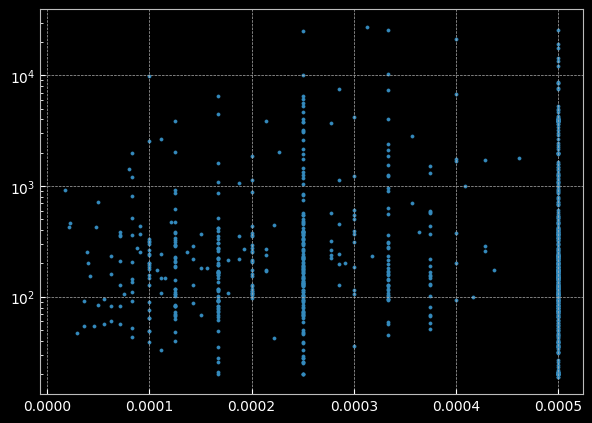

In [ ]:
import matplotlib.pyplot as plt

set_plot_defaults()
plt.figure(figsize=(7,5))
plt.yscale('log')
idx = torch.where(data_rec > 0)[0]
plt.scatter(data_rec[idx], o.pred_ptr[idx], s=5)

In [ ]:
stats.pearsonr(data_rec, o.pred_ptr), stats.spearmanr(data_rec, o.pred_ptr)

(PearsonRResult(statistic=0.11983790934281924, pvalue=7.643619547438852e-08),
 SignificanceResult(statistic=0.19539269080823554, pvalue=1.1663966763028367e-18))

# Representation

In [ ]:
args = XCLearningArguments(
    output_dir='/home/scai/phd/aiz218323/scratch/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/ngame_v-2-100_(mapped)LF-WikiSeeAlsoTitles-320K/',
    index_efs=200,
    representation_num_beams=200,
    generation_length_penalty=1.5,
    per_device_eval_batch_size=64,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()
model = DBT008.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', bsz=bsz, tn_targ=10_000, ig_tok=0)

Some weights of DBT008 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['loss_fn.u', 'loss_fn.v']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import OrderedDict

mname = '/home/scai/phd/aiz218323/scratch/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/ngame_v-2-100_(mapped)LF-WikiSeeAlsoTitles-320K/model_network.pkl'
m_state_dict, msd = OrderedDict(), torch.load(mname)
for k in msd:
    o = k.split('.')
    if o[0] == 'encoder_lbl': m_state_dict['distilbert.'+'.'.join(o[5:])] = msd[k]
model.load_state_dict(m_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['loss_fn.u', 'loss_fn.v'], unexpected_keys=[])

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ngame metrics with beam size 200

## `ngame_data_encoder`

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

  0%|          | 0/2441 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,30.75,20.15,14.96,9.485,30.75,29.7809,30.4016,32.2791,25.5922,26.1697,27.4299,31.6446,25.5922,26.7641,27.9481,30.1355,22.9553,26.6665,36.5629,47.4938,51.4654,55.3664,1.0989,10.9448,182.734,1.462


## `ngame_lbl_encoder`

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

  0%|          | 0/2441 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,30.8,20.2,14.99,9.49,30.8,29.8449,30.4645,32.3239,25.5844,26.2049,27.5213,31.6607,25.5844,26.7878,28.0031,30.1562,22.9453,26.7182,36.5809,47.3577,51.4145,55.2584,1.0989,9.6519,207.213,1.658


## `ngame_data_encoder`

In [ ]:
o = learn.predict(block.test.dset)
display_metric(o.metrics)

  0%|          | 0/2441 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,30.4346,20.076,15.1367,9.5841,30.4346,30.162,31.1365,32.9372,24.8593,26.4293,28.3112,32.3061,24.8593,26.9988,28.5635,30.6118,23.5255,27.4567,37.4628,48.1377,52.2007,56.0578,1.2064,826.1484,214.871,1.679


In [ ]:
pred_dir = f'{args.output_dir}/predictions/'
os.makedirs(pred_dir, exist_ok=True)
torch.save(o, f'{pred_dir}/test_lbl.pth')

## Reranking

In [ ]:
import torch.nn.functional as F

In [ ]:
data_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset)), dim=1)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
lbl_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset.lbl_dset)), dim=1)

  0%|          | 0/2441 [00:00<?, ?it/s]

In [ ]:
pred = torch.load('/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/04-metadata-augmented-trie-for-distilbert/\
distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-168000/predictions/test_lbl_atrie-hlk_n-smp-2000_seed-50.pth')

In [ ]:
from tqdm.auto import tqdm
sc,p = [],0
for q,d in tqdm(zip(pred.pred_ptr.cumsum(0),data_repr), total=data_repr.shape[0]):
    sc.append(d@lbl_repr[pred.pred_idx[p:q]].T);p=q
sc = torch.cat(sc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
o = {
    'pred_idx': pred.pred_idx,
    'pred_ptr': pred.pred_ptr,
    'pred_score': pred.pred_score,
}
o['targ_idx'] = torch.tensor(test_dset.data.data_lbl.indices, dtype=torch.long)
o['targ_ptr'] = torch.tensor([o.getnnz() for o in test_dset.data.data_lbl])

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,7.35,4.233333,3.12,1.935,7.35,6.901783,7.154091,7.651232,4.844966,4.718733,4.95917,5.56795,4.844966,5.106114,5.418912,5.852304,5.631907,6.43026,8.998236,14.566245,18.161182,21.828386


In [ ]:
o['pred_score'] = sc

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,17.45,12.183333,9.28,5.82,17.450001,17.418501,18.010946,19.160732,12.267292,13.833865,15.050716,17.184882,12.267292,13.554461,14.514999,15.698987,12.783868,15.879529,22.626879,26.566772,27.121868,27.479169
